In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import sklearn.metrics

# Description: Predicting the occurrence of seismic events based on geological information from mines
# This is a binary classification problem, where 1 (True) means that a seismic bump occurs in the next shift
# 0 (False) means that a seismic bump will NOT occur in the next shift
# Dataset Source: https://archive.ics.uci.edu/ml/datasets/seismic-bumps

randomSeed = 50

In [4]:
# Columns from data specification provided by dataset authors
columns = ["seismic", "seismoacoustic", "shift", "genergy", "gpuls", "gdenergy", "gdpuls", "ghazard", "nbumps",
          "nbumps2", "nbumps3", "nbumps4", "nbumps5", "nbumps6", "nbumps7", "nbumps89", "energy", "maxenergy", "class"]
# File extension is not .csv, but by removing the comments in the file, it can be imported as a .csv file
data = pd.read_csv("seismic-bumps.arff", names=columns)

In [5]:
print(data)
# There are four non numeric columns that must be converted to a numeric format
print(data.info())
# There is a large difference in the range of values between the columns, so they should be placed on the same scale
# for a better performing algorithm
# Some of the columns also appear to have all 0 values. These columns should be removed as they appear to provide no
# useful information
print(data.describe())

     seismic seismoacoustic shift  genergy  gpuls  gdenergy  gdpuls ghazard  \
0          a              a     N    15180     48       -72     -72       a   
1          a              a     N    14720     33       -70     -79       a   
2          a              a     N     8050     30       -81     -78       a   
3          a              a     N    28820    171       -23      40       a   
4          a              a     N    12640     57       -63     -52       a   
...      ...            ...   ...      ...    ...       ...     ...     ...   
2579       b              a     W    81410    785       432     151       b   
2580       b              a     W    42110    555       213     118       a   
2581       b              a     W    26960    540       101     112       a   
2582       a              a     W    16130    322         2       2       a   
2583       a              a     W    12750    235       -10     -10       a   

      nbumps  nbumps2  nbumps3  nbumps4  nbumps5  n

In [6]:
# The dataset description does not have any mention of missing values, or what format they should take
# Just to be sure, I check for null values here
print(data.isna().any())
# There does not appear to be any null values

seismic           False
seismoacoustic    False
shift             False
genergy           False
gpuls             False
gdenergy          False
gdpuls            False
ghazard           False
nbumps            False
nbumps2           False
nbumps3           False
nbumps4           False
nbumps5           False
nbumps6           False
nbumps7           False
nbumps89          False
energy            False
maxenergy         False
class             False
dtype: bool


In [7]:
# The columns with all 0 values have no correlation value, so this shows that they can be safely removed
print(data.corr())

            genergy     gpuls  gdenergy    gdpuls    nbumps   nbumps2  \
genergy    1.000000  0.748020  0.048514  0.071554  0.220720  0.143587   
gpuls      0.748020  1.000000  0.293036  0.382906  0.300923  0.207390   
gdenergy   0.048514  0.293036  1.000000  0.811944  0.030039  0.041246   
gdpuls     0.071554  0.382906  0.811944  1.000000  0.057996  0.051106   
nbumps     0.220720  0.300923  0.030039  0.057996  1.000000  0.804978   
nbumps2    0.143587  0.207390  0.041246  0.051106  0.804978  1.000000   
nbumps3    0.191753  0.225695 -0.012189  0.014735  0.803364  0.350724   
nbumps4    0.150589  0.256547  0.036916  0.066195  0.395052  0.161296   
nbumps5   -0.009863  0.049450  0.123229  0.141044  0.069613 -0.005251   
nbumps6         NaN       NaN       NaN       NaN       NaN       NaN   
nbumps7         NaN       NaN       NaN       NaN       NaN       NaN   
nbumps89        NaN       NaN       NaN       NaN       NaN       NaN   
energy     0.080828  0.187350  0.105971  0.143277  

In [8]:
# Remove useless columns
data = data.drop(labels=["nbumps6", "nbumps7", "nbumps89"], axis=1)
print(data)

     seismic seismoacoustic shift  genergy  gpuls  gdenergy  gdpuls ghazard  \
0          a              a     N    15180     48       -72     -72       a   
1          a              a     N    14720     33       -70     -79       a   
2          a              a     N     8050     30       -81     -78       a   
3          a              a     N    28820    171       -23      40       a   
4          a              a     N    12640     57       -63     -52       a   
...      ...            ...   ...      ...    ...       ...     ...     ...   
2579       b              a     W    81410    785       432     151       b   
2580       b              a     W    42110    555       213     118       a   
2581       b              a     W    26960    540       101     112       a   
2582       a              a     W    16130    322         2       2       a   
2583       a              a     W    12750    235       -10     -10       a   

      nbumps  nbumps2  nbumps3  nbumps4  nbumps5  e

In [9]:
# Separate the data into features and labels
X = data.iloc[:, 0:-1]
y = data["class"]
print("X: ", X)
print("Y: ", y)

X:       seismic seismoacoustic shift  genergy  gpuls  gdenergy  gdpuls ghazard  \
0          a              a     N    15180     48       -72     -72       a   
1          a              a     N    14720     33       -70     -79       a   
2          a              a     N     8050     30       -81     -78       a   
3          a              a     N    28820    171       -23      40       a   
4          a              a     N    12640     57       -63     -52       a   
...      ...            ...   ...      ...    ...       ...     ...     ...   
2579       b              a     W    81410    785       432     151       b   
2580       b              a     W    42110    555       213     118       a   
2581       b              a     W    26960    540       101     112       a   
2582       a              a     W    16130    322         2       2       a   
2583       a              a     W    12750    235       -10     -10       a   

      nbumps  nbumps2  nbumps3  nbumps4  nbumps

In [10]:
from sklearn.preprocessing import LabelEncoder
# The features seismic, seismoacousatic, shift and ghzard are categorical data consisting of characters. 
# They must be converted to numeric values
X["seismic"] = LabelEncoder().fit_transform(X["seismic"])
X["seismoacoustic"] = LabelEncoder().fit_transform(X["seismoacoustic"])
X["shift"] = LabelEncoder().fit_transform(X["shift"])
X["ghazard"] = LabelEncoder().fit_transform(X["ghazard"])
print(X)

      seismic  seismoacoustic  shift  genergy  gpuls  gdenergy  gdpuls  \
0           0               0      0    15180     48       -72     -72   
1           0               0      0    14720     33       -70     -79   
2           0               0      0     8050     30       -81     -78   
3           0               0      0    28820    171       -23      40   
4           0               0      0    12640     57       -63     -52   
...       ...             ...    ...      ...    ...       ...     ...   
2579        1               0      1    81410    785       432     151   
2580        1               0      1    42110    555       213     118   
2581        1               0      1    26960    540       101     112   
2582        0               0      1    16130    322         2       2   
2583        0               0      1    12750    235       -10     -10   

      ghazard  nbumps  nbumps2  nbumps3  nbumps4  nbumps5  energy  maxenergy  
0           0       0        0  

In [11]:
# Scaling numeric data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Need to turn back into a DataFrame, or preserve the existing DataFrame structure
print(X)

[[-0.73230209 -0.77142023 -1.34374329 ... -0.06830542 -0.24332671
  -0.22108685]
 [-0.73230209 -0.77142023 -1.34374329 ... -0.06830542 -0.14551225
  -0.11774749]
 [-0.73230209 -0.77142023 -1.34374329 ... -0.06830542 -0.24332671
  -0.22108685]
 ...
 [ 1.36555667 -0.77142023  0.74418976 ... -0.06830542 -0.24332671
  -0.22108685]
 [-0.73230209 -0.77142023  0.74418976 ... -0.06830542 -0.24332671
  -0.22108685]
 [-0.73230209 -0.77142023  0.74418976 ... -0.06830542 -0.24332671
  -0.22108685]]


In [12]:
#Setting up splits
from sklearn.model_selection import train_test_split
#I wasn't sure if we would want the partitions randomized, so I made a randomized and unrandomized verson.  
#If we don't end up needing the unrandomized version, I can easily take it out, but I thought I'd put it there just in case.
# From Jacob: There's no disadvantage to shuffling, so I removed the unshuffled version
trainX, testX, trainY, testY = train_test_split(X, y, random_state=randomSeed)

#I printed the shape as well to confirm it is working properly since the arrays are a bit hard to interpret at the moment

print(trainX)
print(trainX.shape)
print(testX)
print(testX.shape)
print(trainY)
print(testY)

[[-0.73230209 -0.77142023 -1.34374329 ... -0.06830542 -0.11616791
  -0.11774749]
 [-0.73230209 -0.77142023 -1.34374329 ... -0.06830542 -0.24332671
  -0.22108685]
 [-0.73230209 -0.77142023  0.74418976 ... -0.06830542  0.23596412
   0.24394029]
 ...
 [-0.73230209 -0.77142023 -1.34374329 ... -0.06830542 -0.24332671
  -0.22108685]
 [ 1.36555667 -0.77142023  0.74418976 ... -0.06830542 -0.24332671
  -0.22108685]
 [-0.73230209  1.12339905  0.74418976 ... -0.06830542 -0.24332671
  -0.22108685]]
(1938, 15)
[[-0.73230209 -0.77142023  0.74418976 ... -0.06830542 -0.24332671
  -0.22108685]
 [-0.73230209 -0.77142023  0.74418976 ... -0.06830542 -0.24332671
  -0.22108685]
 [ 1.36555667  1.12339905  0.74418976 ... -0.06830542 -0.22865454
  -0.20558595]
 ...
 [-0.73230209  3.01821832  0.74418976 ... -0.06830542 -0.24332671
  -0.22108685]
 [-0.73230209 -0.77142023  0.74418976 ... -0.06830542 -0.24332671
  -0.22108685]
 [ 1.36555667 -0.77142023  0.74418976 ... -0.06830542 -0.03791635
  -0.11774749]]
(646,

In [13]:
logClassifier = LogisticRegression(random_state=randomSeed).fit(trainX, trainY)
logScores = cross_val_score(logClassifier, testX, testY)
print(logScores)
logPred = logClassifier.predict(testX)
# The accuracy is very high, but this is due to the unbalanced data set and complexity of the data set
# Precision and recall are both 0 because the classifier was unable to correctly classify any positive instances
print(sklearn.metrics.accuracy_score(testY, logPred))
print(sklearn.metrics.precision_score(testY, logPred, average='binary', pos_label=1))
print(sklearn.metrics.recall_score(testY, logPred, average='binary', pos_label=1))

[0.91538462 0.93023256 0.93023256 0.89147287 0.92248062]
0.9195046439628483
0.0
0.0


In [14]:
# Even a random forest classifier has the same difficulty
randomForestClassifier = RandomForestClassifier(random_state=randomSeed).fit(trainX, trainY)
randomForestScores = cross_val_score(randomForestClassifier, testX, testY)
print(randomForestScores)
randomForestPred = randomForestClassifier.predict(testX)
print(sklearn.metrics.accuracy_score(testY, randomForestPred))
print(sklearn.metrics.precision_score(testY, logPred, average='binary', pos_label=1))
print(sklearn.metrics.recall_score(testY, logPred, average='binary', pos_label=1))

[0.92307692 0.9379845  0.93023256 0.92248062 0.91472868]
0.9272445820433437
0.0
0.0


In [15]:
# How unbalanced is the dataset?
posCount = (y == 1).sum()
negCount = (y == 0).sum()
print("Positive instances: ", posCount)
print("Negative instances: ", negCount)
print("Positive Percentage: ", posCount / negCount)
print("The dataset is very unbalanced - only 7% of the classes are positive. This has to be resolved.");

Positive instances:  170
Negative instances:  2414
Positive Percentage:  0.07042253521126761
The dataset is very unbalanced - only 7% of the classes are positive. This has to be resolved.


In [16]:
#I think this helped.  The accuracy isnt as good but its actually predicting now.
#the accuracy didnt tank quite as much as I thought it would.
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clfSVC = SVC(kernel='linear', class_weight='balanced', probability=True)
clfSVC.fit(trainX, trainY)
predSVC = clfSVC.predict(testX)
print(predSVC)
print( accuracy_score(testY, predSVC) )
SVCScores = cross_val_score(clfSVC, testX, testY)
print(SVCScores)
print(sklearn.metrics.precision_score(testY, predSVC, average='binary', pos_label=1))
print(sklearn.metrics.recall_score(testY, predSVC, average='binary', pos_label=1))

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0
 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1
 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0
 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0
 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0
 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1
 0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1
 0 0 1 0 0 1 0 0 1 0 0 0 

In [17]:
# Balancing data by upsampling
from sklearn.utils import resample
data_majority = data[data['class'] == 0]
data_minority = data[data['class'] == 1]
data_minority_upsampled = resample(data_minority, replace=True, n_samples=len(data_majority), random_state=randomSeed)
dataJoined = pd.concat([data_majority, data_minority_upsampled])
print(dataJoined)

# Preprocess upsampled data
upX = dataJoined.iloc[:, 0:-1]
upy = dataJoined["class"]
upX["seismic"] = LabelEncoder().fit_transform(upX["seismic"])
upX["seismoacoustic"] = LabelEncoder().fit_transform(upX["seismoacoustic"])
upX["shift"] = LabelEncoder().fit_transform(upX["shift"])
upX["ghazard"] = LabelEncoder().fit_transform(upX["ghazard"])
upX = scaler.fit_transform(upX)

     seismic seismoacoustic shift  genergy  gpuls  gdenergy  gdpuls ghazard  \
0          a              a     N    15180     48       -72     -72       a   
1          a              a     N    14720     33       -70     -79       a   
2          a              a     N     8050     30       -81     -78       a   
3          a              a     N    28820    171       -23      40       a   
4          a              a     N    12640     57       -63     -52       a   
...      ...            ...   ...      ...    ...       ...     ...     ...   
284        b              a     W   932410   2464        47      28       a   
652        b              a     W    51230    944       -10       8       a   
404        b              b     W    68970    624        71      94       a   
695        b              b     W   306400   2522       112      98       b   
1521       b              b     W    42220    515       159      79       a   

      nbumps  nbumps2  nbumps3  nbumps4  nbumps5  e

In [26]:
# Testing classifiers with upsampled data
upTrainX, upTestX, upTrainY, upTestY = train_test_split(upX, upy, random_state=randomSeed)
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
upsampledClfSVC = SVC(kernel='linear', class_weight='balanced', probability=True)
upsampledClfSVC.fit(upTrainX, upTrainY)
upsampledPredSVC = upsampledClfSVC.predict(upTestX)
print(upsampledPredSVC)
print( accuracy_score(upTestY, upsampledPredSVC) )
upsampledSVCScores = cross_val_score(upsampledClfSVC, upTestX, upTestY)
print(upsampledSVCScores)
print(sklearn.metrics.precision_score(upTestY, upsampledPredSVC, average='binary', pos_label=1))
print(sklearn.metrics.recall_score(upTestY, upsampledPredSVC, average='binary', pos_label=1))

[1 0 1 ... 1 0 0]
0.7307373653686827
[0.69008264 0.7107438  0.69709544 0.70954357 0.74688797]
0.79182156133829
0.6666666666666666


C:\Users\jacob\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass sample_weight=Upsampled SVC Classifier as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


ValueError: Found input variables with inconsistent numbers of samples: [1207, 1207, 24]

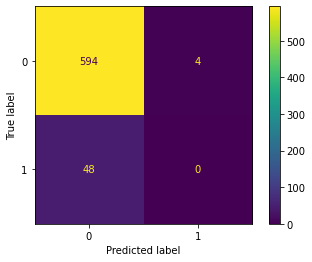

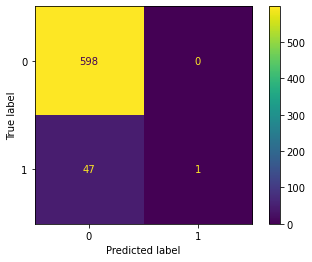

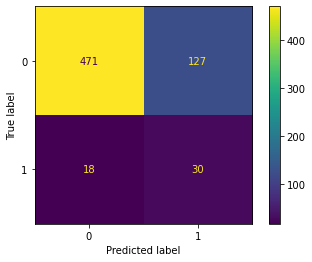

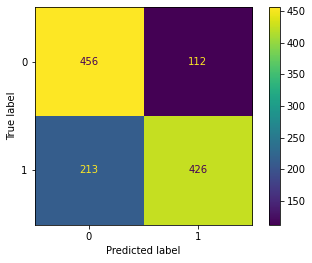

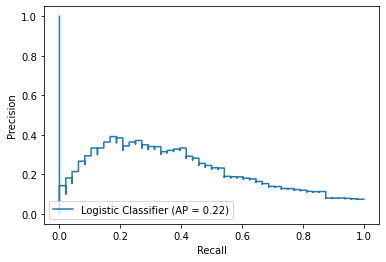

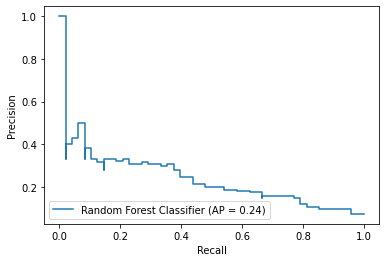

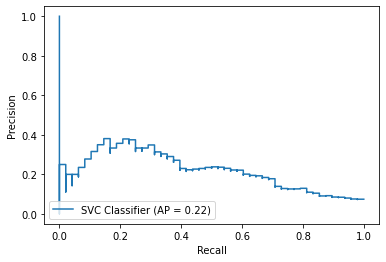

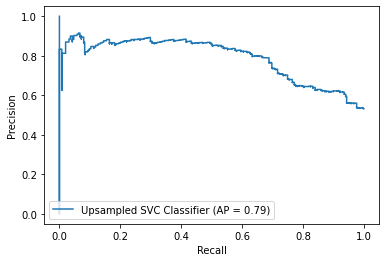

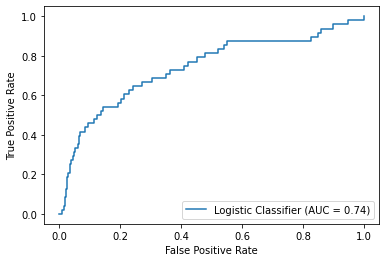

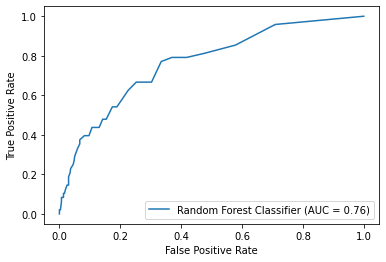

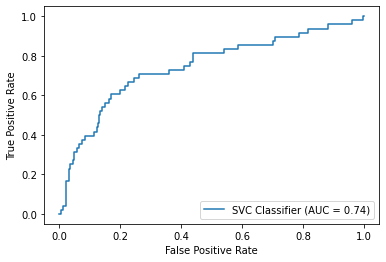

In [36]:
# Visualizations useful for final project paper
# Confusion Matrices
from sklearn.metrics import plot_confusion_matrix
logConfusion = plot_confusion_matrix(logClassifier, testX, testY)
randomForestConfusion = plot_confusion_matrix(randomForestClassifier, testX, testY)
clfSVCConfusion = plot_confusion_matrix(clfSVC, testX, testY)
upsampledclfSVCConfusion = plot_confusion_matrix(upsampledClfSVC, upTestX, upTestY)
# Precision Recall Curve
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
logPRC = plot_precision_recall_curve(logClassifier, testX, testY, name="Logistic Classifier")
randomForestPRC = plot_precision_recall_curve(randomForestClassifier, testX, testY, name="Random Forest Classifier")
clfSVCPRC = plot_precision_recall_curve(clfSVC, testX, testY, name="SVC Classifier")
upsampledclfSVCPRC = plot_precision_recall_curve(upsampledClfSVC, upTestX, upTestY, name="Upsampled SVC Classifier")
# ROC Curves
from sklearn.metrics import plot_roc_curve
logROC = plot_roc_curve(logClassifier, testX, testY, name="Logistic Classifier")
randomForestROC = plot_roc_curve(randomForestClassifier, testX, testY, name="Random Forest Classifier")
clfSVCROC = plot_roc_curve(clfSVC, testX, testY, name="SVC Classifier")
upsampledclfSVCROC = plot_roc_curve(upsampledClfSVC, upTestX, upTestY, name="Upsampled SVC Classifier")